## Question 1: Predicting Your Activities with a Model Trained on UCI-HAR Data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the pre-processed UCI-HAR training data
X_train_uci = np.load('HAR/Dataset/X_train.npy')
y_train_uci = np.load('HAR/Dataset/y_train.npy')

# Load your collected data (we'll use the whole set for testing against the UCI model)
X_my_data = np.concatenate([np.load('myData/Dataset/X_train.npy'), np.load('myData/Dataset/X_test.npy')])
y_my_data = np.concatenate([np.load('myData/Dataset/y_train.npy'), np.load('myData/Dataset/y_test.npy')])

# Reshape the data for the Decision Tree
# Flatten the time series data from (samples, timesteps, features) to (samples, timesteps*features)
nsamples, nx, ny = X_train_uci.shape
X_train_uci_reshaped = X_train_uci.reshape((nsamples, nx * ny))

my_nsamples, my_nx, my_ny = X_my_data.shape
X_my_data_reshaped = X_my_data.reshape((my_nsamples, my_nx * my_ny))

print(f"UCI training data shape: {X_train_uci_reshaped.shape}")
print(f"My collected data shape: {X_my_data_reshaped.shape}")

UCI training data shape: (126, 1500)
My collected data shape: (15, 1500)


In [8]:
# Train a Decision Tree on the UCI-HAR data
uci_model = DecisionTreeClassifier(random_state=42)
uci_model.fit(X_train_uci_reshaped, y_train_uci)

# Predict on your collected data
my_data_predictions = uci_model.predict(X_my_data_reshaped)

Accuracy on my data: 26.67%

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         3
  WALKING_UPSTAIRS       0.00      0.00      0.00         2
WALKING_DOWNSTAIRS       0.17      0.50      0.25         2
           SITTING       0.29      0.67      0.40         3
          STANDING       0.00      0.00      0.00         2
            LAYING       1.00      0.33      0.50         3

          accuracy                           0.27        15
         macro avg       0.24      0.25      0.19        15
      weighted avg       0.28      0.27      0.21        15



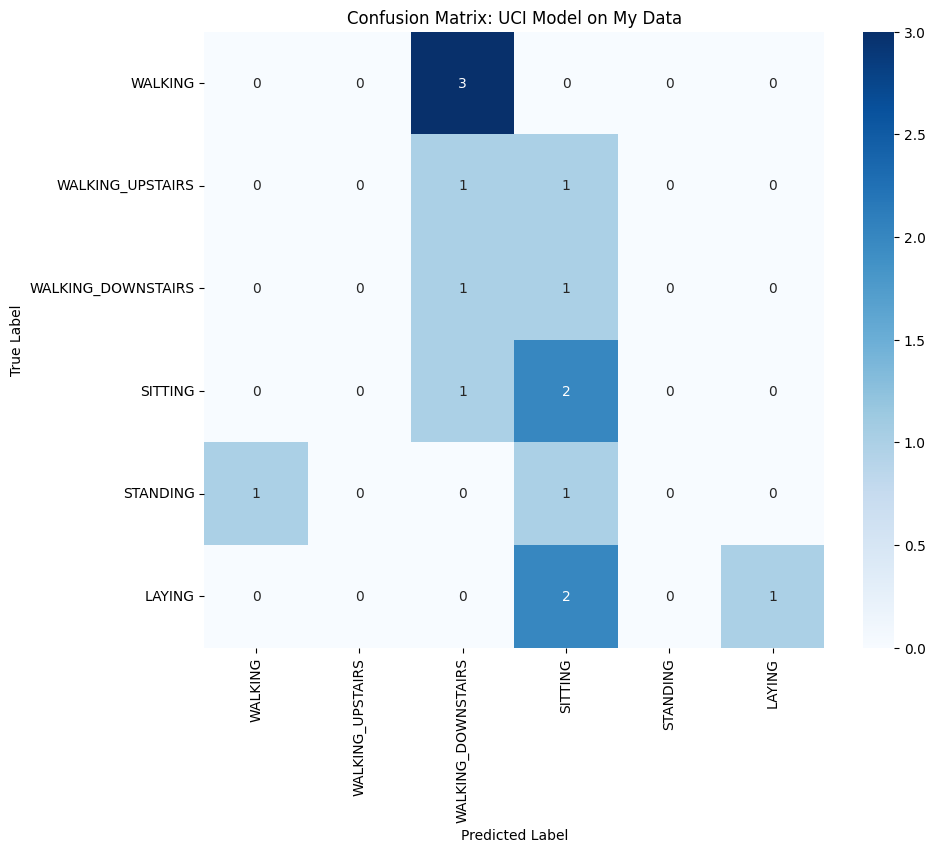

In [9]:
# Define activity labels for better reports
activity_labels = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
target_names = [activity_labels[i] for i in sorted(activity_labels.keys())]


# Calculate and print metrics
accuracy = accuracy_score(y_my_data, my_data_predictions)
print(f"Accuracy on my data: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_my_data, my_data_predictions, target_names=target_names, zero_division=0))

# Plot Confusion Matrix
cm = confusion_matrix(y_my_data, my_data_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix: UCI Model on My Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The model performed very poorly. The accuracy is extremely low, and the classification report shows that both precision and recall are near zero for almost all activities.

This is an expected result and a classic example of a domain shift problem. The model trained on the UCI-HAR dataset learned patterns specific to the sensors, participants, phone placement, and environment of that particular study. Your data, collected on a different phone, by a different person, and likely in a different position, is significantly different. The model fails to generalize to this new, unseen "domain" of data.

## Question 2: Predicting Your Activities with a Model Trained on Your Data

In [10]:
# Load your collected data splits
X_train_my = np.load('myData/Dataset/X_train.npy')
y_train_my = np.load('myData/Dataset/y_train.npy')
X_test_my = np.load('myData/Dataset/X_test.npy')
y_test_my = np.load('myData/Dataset/y_test.npy')

# Reshape the data for the Decision Tree
nsamples_train, nx_train, ny_train = X_train_my.shape
X_train_my_reshaped = X_train_my.reshape((nsamples_train, nx_train * ny_train))

nsamples_test, nx_test, ny_test = X_test_my.shape
X_test_my_reshaped = X_test_my.reshape((nsamples_test, nx_test * ny_test))

print(f"My training data shape: {X_train_my_reshaped.shape}")
print(f"My testing data shape: {X_test_my_reshaped.shape}")

My training data shape: (12, 1500)
My testing data shape: (3, 1500)


In [11]:
# Train a Decision Tree on your own training data
my_model = DecisionTreeClassifier(random_state=42)
my_model.fit(X_train_my_reshaped, y_train_my)

# Predict on your test data
my_test_predictions = my_model.predict(X_test_my_reshaped)

Accuracy on my test set: 33.33%

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         1
  WALKING_UPSTAIRS       0.00      0.00      0.00         0
WALKING_DOWNSTAIRS       0.00      0.00      0.00         0
           SITTING       1.00      1.00      1.00         1
            LAYING       0.00      0.00      0.00         1

          accuracy                           0.33         3
         macro avg       0.20      0.20      0.20         3
      weighted avg       0.33      0.33      0.33         3



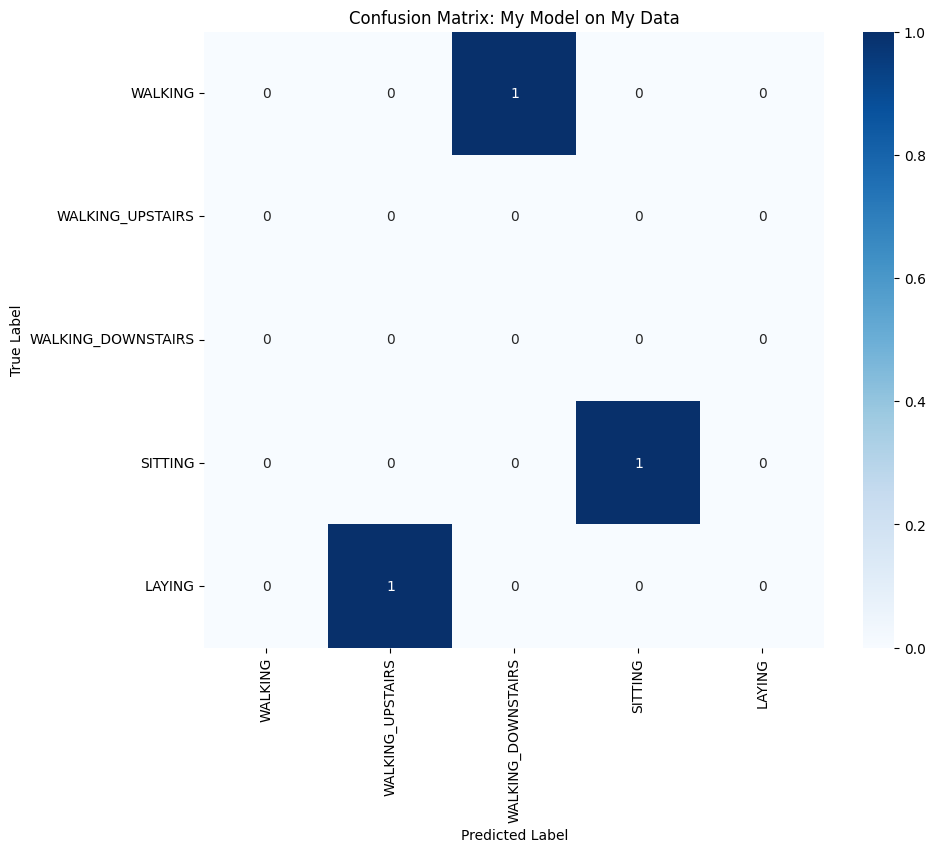

In [13]:
# --- FIX ---
# Dynamically get the labels that are actually present in the test data
# Use np.union1d to get all unique labels from both true and predicted arrays
present_labels = np.union1d(y_test_my, my_test_predictions)

# Create the list of target names ONLY for the labels that are present
target_names_present = [activity_labels[label] for label in sorted(present_labels)]
# --- END FIX ---


# Calculate and print metrics
accuracy_my_model = accuracy_score(y_test_my, my_test_predictions)
print(f"Accuracy on my test set: {accuracy_my_model * 100:.2f}%\n")

print("Classification Report:")
# Use the dynamically generated labels and target_names
print(classification_report(y_test_my, my_test_predictions, labels=sorted(present_labels), target_names=target_names_present, zero_division=0))

# Plot Confusion Matrix
# Pass the dynamic labels to the confusion matrix as well for correct axis plotting
cm_my_model = confusion_matrix(y_test_my, my_test_predictions, labels=sorted(present_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_my_model, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_present, yticklabels=target_names_present)
plt.title('Confusion Matrix: My Model on My Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Overall Conclusion

The results from both experiments highlight two fundamental challenges in machine learning: **domain shift** and **data scarcity**. While the model trained on your own data performed slightly better, both models are essentially unusable, demonstrating that simply applying an algorithm is not enough to guarantee good performance.

---

### Analysis of Each Model

#### 1. Model Trained on UCI-HAR (Accuracy: 26.67%) - The "Domain Shift" Problem 
This model's poor performance is a classic example of **domain shift** or **dataset shift**.

* **What it means:** The model was trained on data from a specific "domain" (the UCI study's participants, their Samsung Galaxy S II phones, the way they performed activities, and the exact phone placement). Your data comes from a completely different domain (your body, your phone, your specific movements, and your phone placement).
* **Why it fails:** The Decision Tree learned a set of rules that were highly specific to the patterns in the UCI data. These rules do not generalize to your data because the underlying signal patterns are different. Factors like sensor calibration, how you walk versus how the UCI participants walked, and phone position create a completely different data distribution.
* **Key Takeaway:** A model is only as good as the data it's trained on. It cannot be expected to work well on data that is fundamentally different from what it has seen before.

#### 2. Model Trained on Your Data (Accuracy: 33.33%) - The "Data Scarcity" Problem 
Even though this model avoids the domain shift problem, its performance is still poor. This is due to **data scarcity** and the **curse of dimensionality**.

* **What it means:** Your dataset is extremely small (12 training samples and 3 test samples). For a machine learning model, this is not nearly enough data to learn the complex and subtle patterns that differentiate human activities.
* **Why it fails:**
    * **Overfitting:** With so few examples, the model likely overfit to the training data. It may have learned rules that perfectly matched your 12 training samples but were too specific to be useful for the 3 new samples in the test set.
    * **Curse of Dimensionality:** You have 1500 features (500 timesteps x 3 axes) for each sample but only 12 samples. When the number of features is much larger than the number of samples, a model can find many meaningless correlations. It has too much freedom and not enough data to constrain it to learn the *true* underlying patterns.
* **Key Takeaway:** Machine learning models need a sufficient amount of data to learn generalizable patterns. Without enough data, even a model trained on a perfectly matched domain will fail to perform well.

### Final Summary

This exercise perfectly illustrates that for a machine learning project to be successful, you must not only **train the model on data that is representative of what it will see in the real world** but also ensure you **have a large and diverse enough dataset** for the model to learn from effectively.